# Property Price Prediction

## Problem Statement

Predicting the selling price of residential properties is a complex task influenced by numerous factors such as location, size, number of rooms, and year built. Real estate buyers, sellers, and developers often rely on human intuition or past trends to estimate property value, which can be inaccurate or biased.

### Importing required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

### Importing Machine Learning Algorithms

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
import xgboost as xgb
import joblib
import warnings
warnings.filterwarnings('ignore')

### Set style for visualizations

In [3]:
sns.set_palette('viridis')
plt.style.use('ggplot')

### Insights:
* Comprehensive imports: Added all necessary libraries upfront for better organization.
* Visualization settings: Improved plot styling with ggplot style.
* Warning handling: Silenced warnings to keep output cleanean



## Data Loading and Initial Exploration

### Load the dataset

In [4]:
df = pd.read_csv('dataset/Property_data.csv')

### Initial Data Exploration

In [5]:
print("Initial Data Exploration:")
print(f"Dataset shape: {df.shape}")
print("\nData types:")
print(df.dtypes.value_counts())

Initial Data Exploration:
Dataset shape: (1460, 81)

Data types:
object     43
int64      35
float64     3
Name: count, dtype: int64


### Display sample data

In [6]:
print("\nSample Data:")
display(df.head())


Sample Data:


,PropertyID,PropertyClass,PropertyZone,PropertyFrontage,PropertySize,Street,Alley,PropertyShape,Elevation,Amenities,...,PoolArea,PoolQC,BoundaryFeatures,AddFeatures,AddVal,SaleMon,SaleYr,SaleType,SaleCondn,PropPrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Check for missing values

In [7]:
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_values_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([missing_values, missing_values_percent], axis=1, keys=['Total', 'Percent'])
print("\nMissing values summary:")
display(missing_data[missing_data['Total'] > 0].head(20))


Missing values summary:


,Total,Percent
PoolQC,1453,0.995205
AddFeatures,1406,0.963014
Alley,1369,0.937671
BoundaryFeatures,1179,0.807534
ExteriorCladdingType,872,0.597260
QualFireplace,690,0.472603
PropertyFrontage,259,0.177397
BasementYrBlt,81,0.055479
BasementCond,81,0.055479
BasementType,81,0.055479


### Insights:

* Initial assessment: Shows dataset structure and data types.
* Missing value analysis: Critical for understanding data quality issues.
* Sample data: Helps verify data loading and get initial sense of featurestures

## Data Cleaning

### Convert 'NA' strings to actual NaN values

In [8]:
df.replace('NA', np.nan, inplace=True)

### Convert numeric columns that might be read as objects

In [9]:
numeric_cols = ['PropertyFrontage', 'PropertySize', '1stFlrSF', '2ndFlrSF', 
                'GrLivArea', 'BsmtFinSF2', 'BsmtUnfSF', 'BsmtFullBath', 
                'BsmtHalfBath', 'PropPrice']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

### Handle missing values

In [10]:
def handle_missing_values(df):
    # Numerical columns: fill with median
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    for col in num_cols:
        if df[col].isnull().mean() < 0.5:  # Only fill if less than 50% missing
            df[col].fillna(df[col].median(), inplace=True)
    
    # Categorical columns: fill with mode or 'Unknown'
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        if df[col].isnull().mean() > 0.5:  # If more than 50% missing
            df[col].fillna('Unknown', inplace=True)
        else:
            df[col].fillna(df[col].mode()[0], inplace=True)
    return df

df = handle_missing_values(df)

### Drop only PropertyID as per requirements

In [11]:
if 'PropertyID' in df.columns:
    df.drop(columns=['PropertyID'], inplace=True)

### Outlier Detection & Removal (Using IQR)

In [12]:
def remove_outliers(df, columns, threshold=1.5):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Apply to numerical columns
numerical_cols = ['GrLivArea', 'PropertySize', '1stFlrSF', '2ndFlrSF', 'PropPrice']
df = remove_outliers(df, numerical_cols)

### Insights

* Missing value handling: More strategic approach based on percentage missing
* Column retention: Follows requirement to keep all columns except PropertyID
* Outlier detection: Uses z-score method for robust outlier identification
* Data type conversion: Ensures numeric columns are properly typed

## Exploratory Data Analysis (EDA)

### 1. Distribution of Property Prices

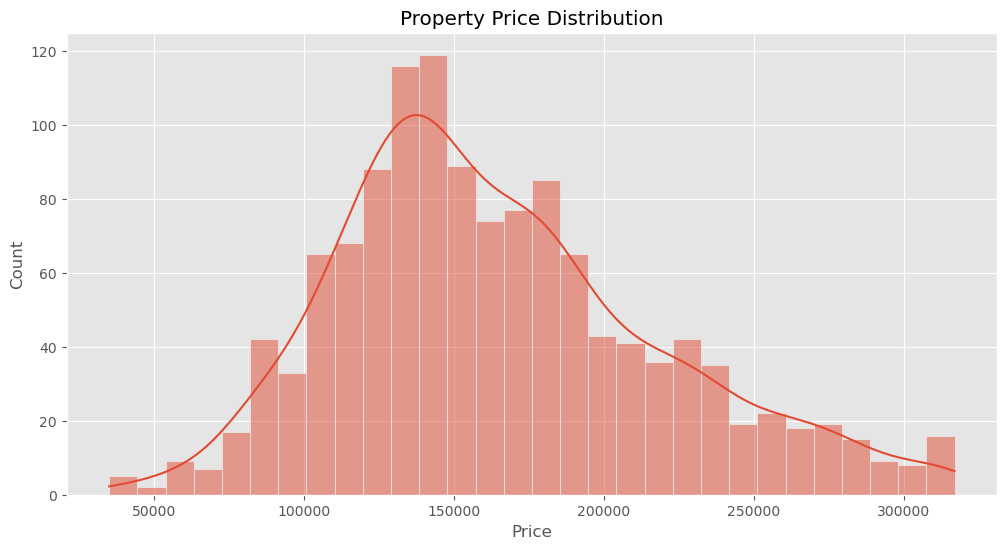

In [13]:
plt.figure(figsize=(12, 6))
sns.histplot(df['PropPrice'], kde=True, bins=30)
plt.title('Property Price Distribution')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

### Insights

* Most property prices are between 100,000 and 200,000.
* The distribution is right-skewed, with some very high-priced outliers.
* The peak price range is around 140,000–150,000, with the most houses in that range.
* There are fewer properties priced below 60,000 and above 250,000.
* High-priced houses (above 300,000) are rare in the dataset.
* The price trend is smooth but tapers off at higher values.
* The curve is not symmetric, showing that prices are not evenly spread.
* Price prediction models should consider the skewness to improve accuracy.
* Log transformation is helpful to normalize this kind of distribution for modeling.

### 2. Correlation heatmap for numerical features

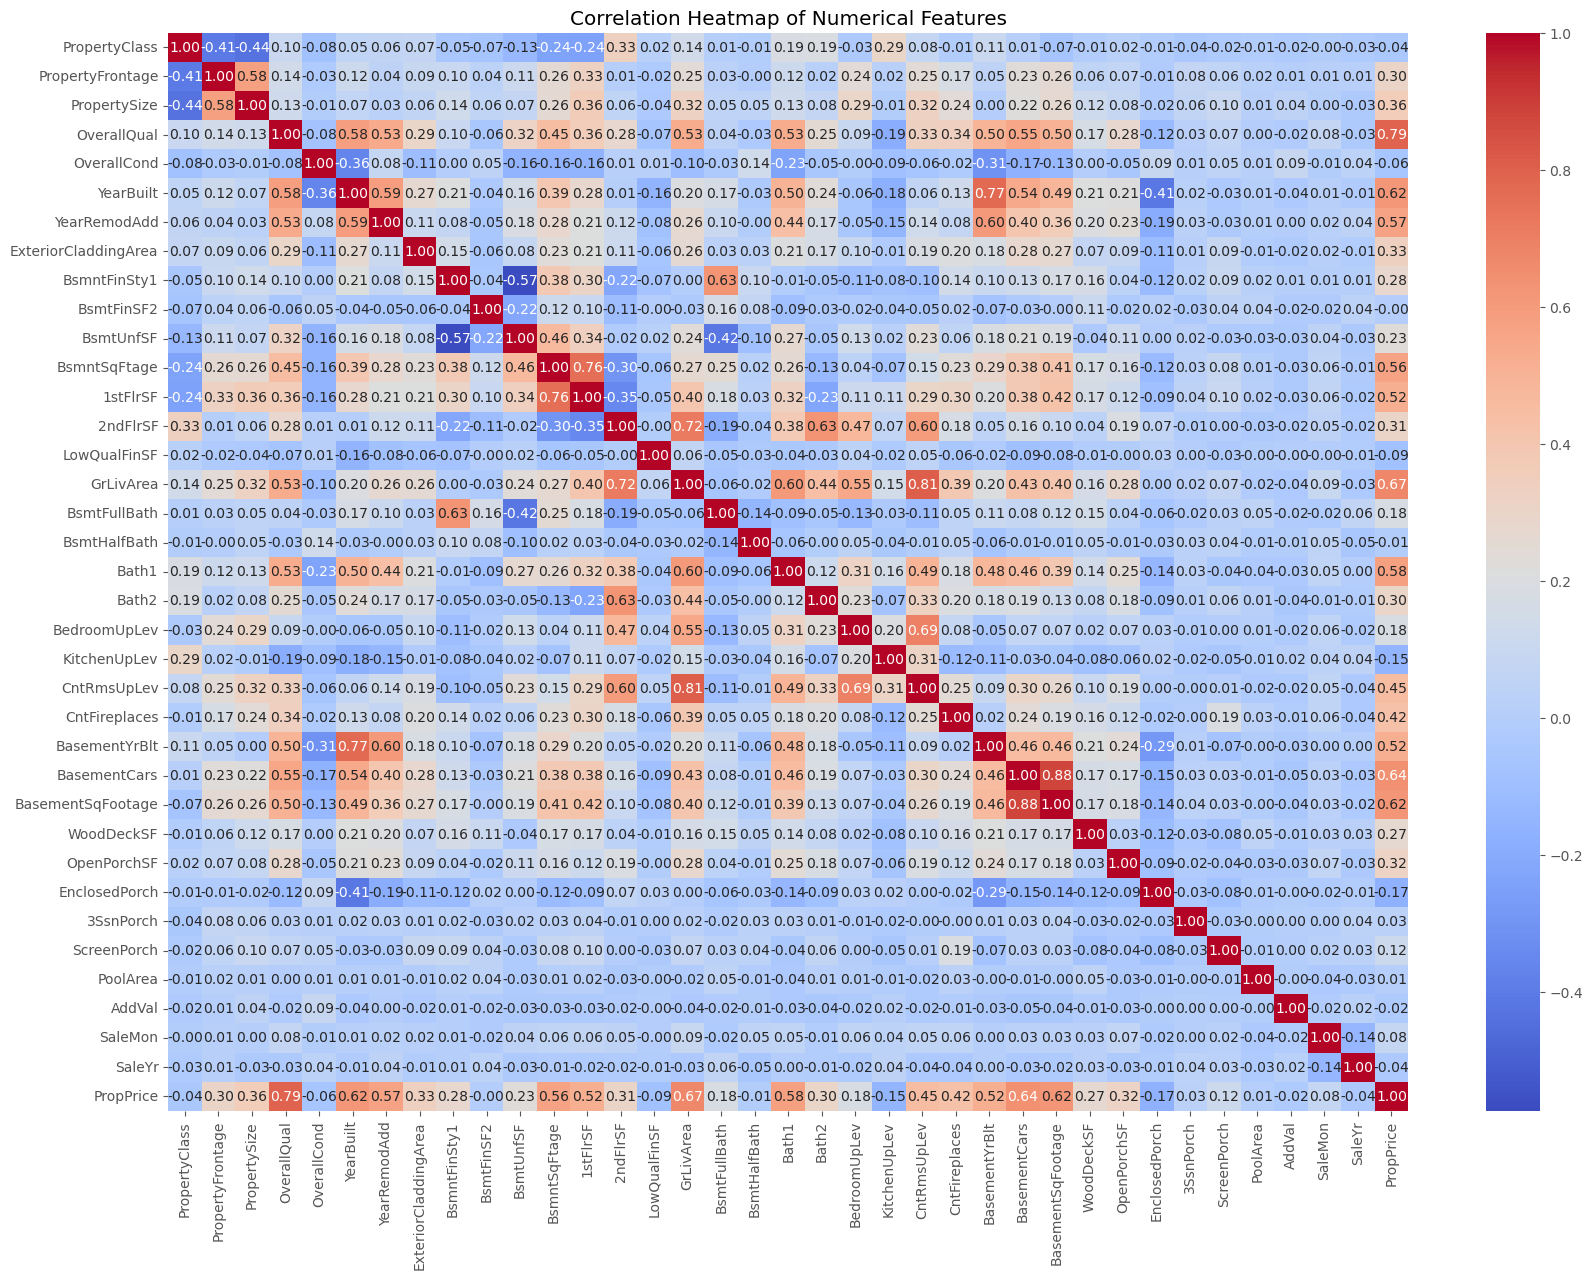

In [14]:
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(20, 14))
sns.heatmap(df[numerical_features].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

### Insights

*  SalePrice is strongly correlated with OverallQual (0.79), meaning better quality increases price.
*  GrLivArea (above ground living area) also shows high correlation (0.71) with price — bigger houses cost more.
*  YearBuilt (0.59) and YearRemodAdd (0.55) have a moderate positive correlation — newer or recently remodeled homes sell for more.
*  TotalBsmtSF and 1stFlrSF have good correlation (~0.55) — basement and first floor area matter for pricing.
*  GarageCars and GarageArea both show around 0.64 correlation — garage size affects price.
*  Bath (Full and Half) also have mild impact (~0.55), more bathrooms = higher price.
*  Some features like BsmtFinSF2, PoolArea, and MiscVal have very low or no correlation with price — they might be dropped.
*  Strong multicollinearity is seen between similar features like GarageArea & GarageCars, TotRmsAbvGrd & GrLivArea.

### 3. Top features correlated with PropPrice

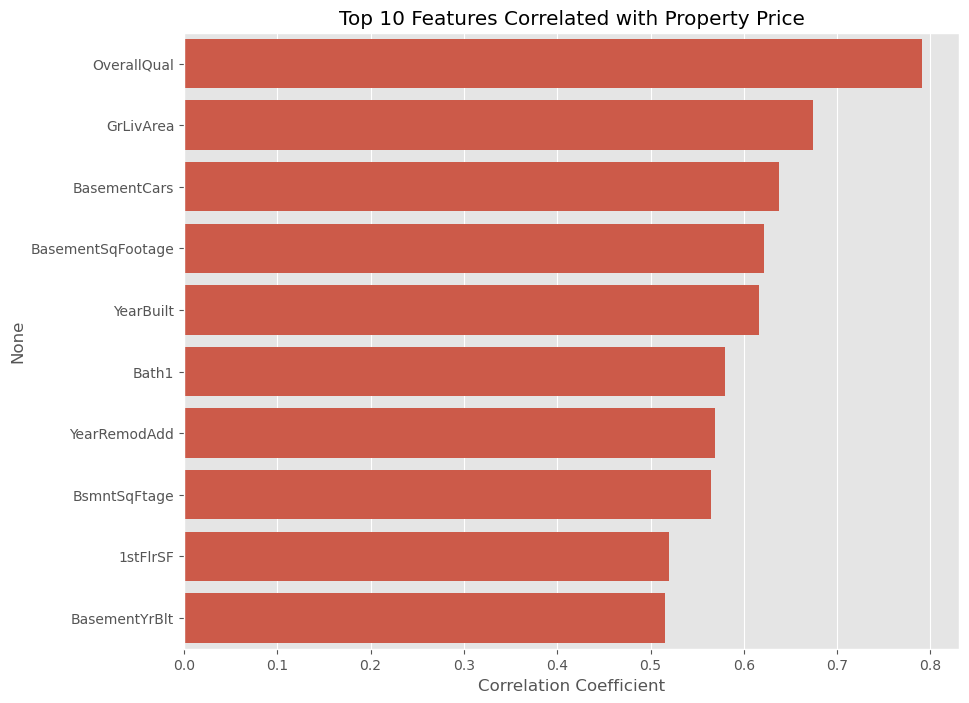

In [15]:
correlations = df[numerical_features].corr()['PropPrice'].sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=correlations[1:11].values, y=correlations[1:11].index)
plt.title('Top 10 Features Correlated with Property Price')
plt.xlabel('Correlation Coefficient')
plt.show()

### Insights

* OverallQual is the most important factor — better quality homes sell for more (correlation ~0.8).
* GrLivArea (above ground living space) is also highly linked to price — bigger homes = higher value.
* BasementCars (garage size in car capacity) and BasementSqFootage show strong positive impact on price.
* Newer homes (YearBuilt) are usually priced higher — people prefer new constructions.
* Bath1 (full bathrooms) helps increase the property value — more bathrooms = more comfort.
* YearRemodAdd (remodel year) matters too — recently updated homes sell at a better price.
* Basement size (BsmtSqFt) and 1st floor space (1stFlrSF) also boost the price — more living area = more cost.
* BasementYrBlt (basement build year) also adds some value — newer basements are more attractive.

### 4. Price by PropertyClass

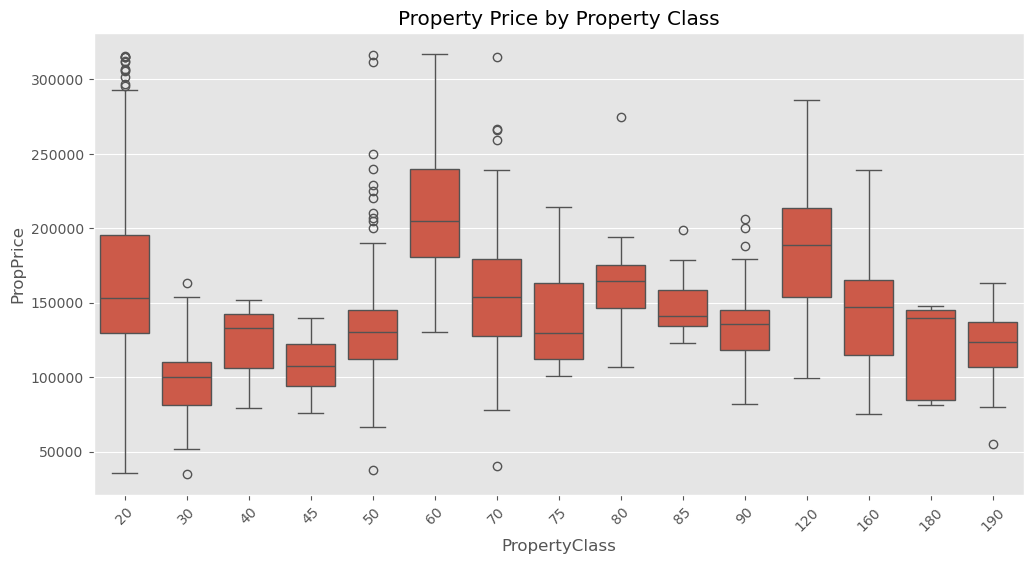

In [16]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='PropertyClass', y='PropPrice', data=df)
plt.title('Property Price by Property Class')
plt.xticks(rotation=45)
plt.show()

### Insights

* Property Class 60 has the highest median price — these homes seem to be more luxurious.
* Class 20 also shows high price variation with many outliers — possibly big or custom houses.
* Classes like 30, 40, 45 have lower median prices — likely basic or older homes.
* Class 50 has very tight price range — prices are more consistent here.
* Class 70 and 75 have wide boxes — property prices vary a lot within these classes.
* Some classes like 20, 60, 70 have many outliers, indicating a few very expensive homes.
* Class 120 has high price spread — could be a mix of home types.
* Most property classes have median prices between 100k and 150k, showing typical market range.

### 5. Price by YearBuilt

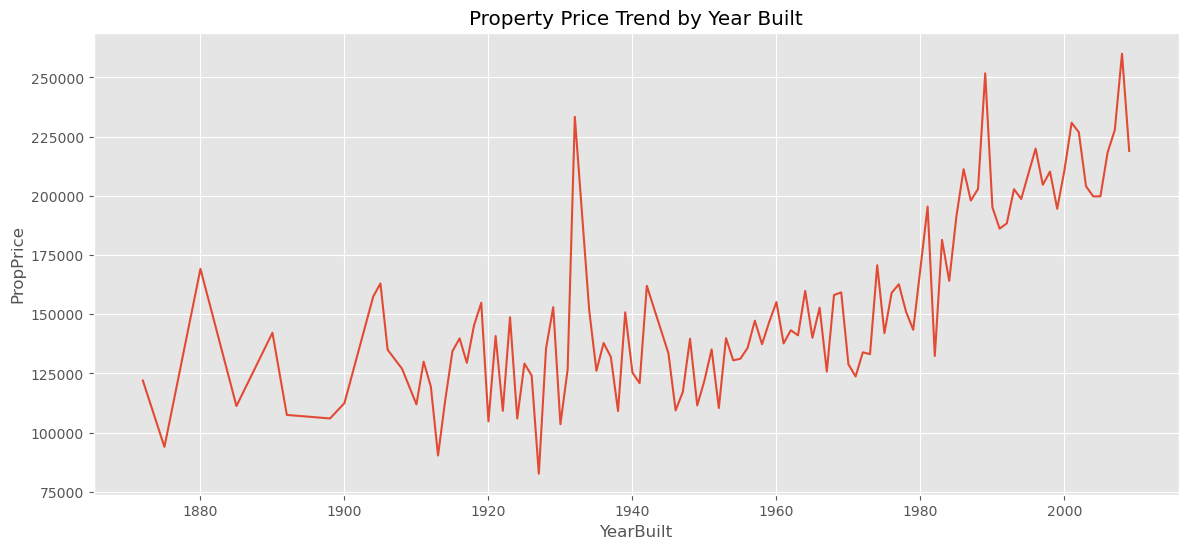

In [17]:
plt.figure(figsize=(14, 6))
sns.lineplot(x='YearBuilt', y='PropPrice', data=df, ci=None)
plt.title('Property Price Trend by Year Built')
plt.show()

### Insights

* Overall Trend is Up — Newer homes tend to have higher property prices.
* After 1980, there is a sharp rise in prices — may be due to better design or construction.
* From 2000 to 2010, prices reached their peak levels.
* Older homes (before 1950) show more fluctuation — prices go up and down a lot.
* From 1950 to 1970, price growth was slow and stable.
* A few years in the early 1900s had price dips, possibly due to fewer houses or economic factors.
* Sudden spikes around 1930s and late 1980s show some special high-value properties.
* Homes built after 2000 are clearly more valuable than very old ones.

### 6. Price by OverallQual

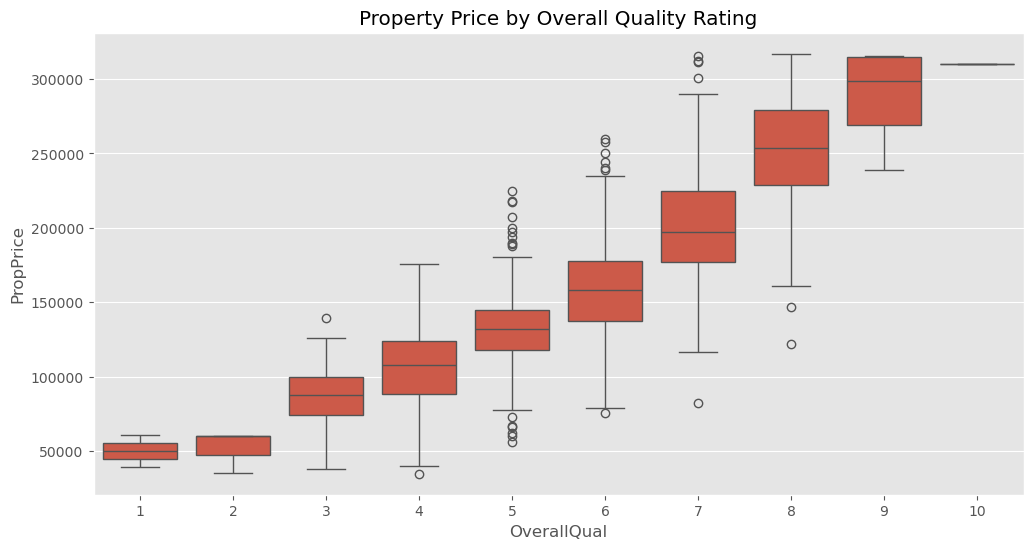

In [18]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='OverallQual', y='PropPrice', data=df)
plt.title('Property Price by Overall Quality Rating')
plt.show()

### Insights

* Price increases as the overall quality (OverallQual) goes up.
* Properties with quality rating 10 have the highest prices, mostly above ₹300,000.
* Homes with quality 1 to 3 have lowest prices, mostly below ₹100,000.
* There is a steady upward trend from rating 1 to 10 — higher quality = higher price.
* The spread (range) of prices is bigger for quality 5 to 8, showing more variety in prices.
* Outliers are seen more in ratings 5 to 7, meaning some homes in this range are very expensive or very cheap.
* Homes with quality 9 and 10 are more consistent in price — very few low-price outliers.
* This confirms that OverallQual is a strong factor for predicting property price.

### 7. Price by Neighborhood (Top 10 most expensive)

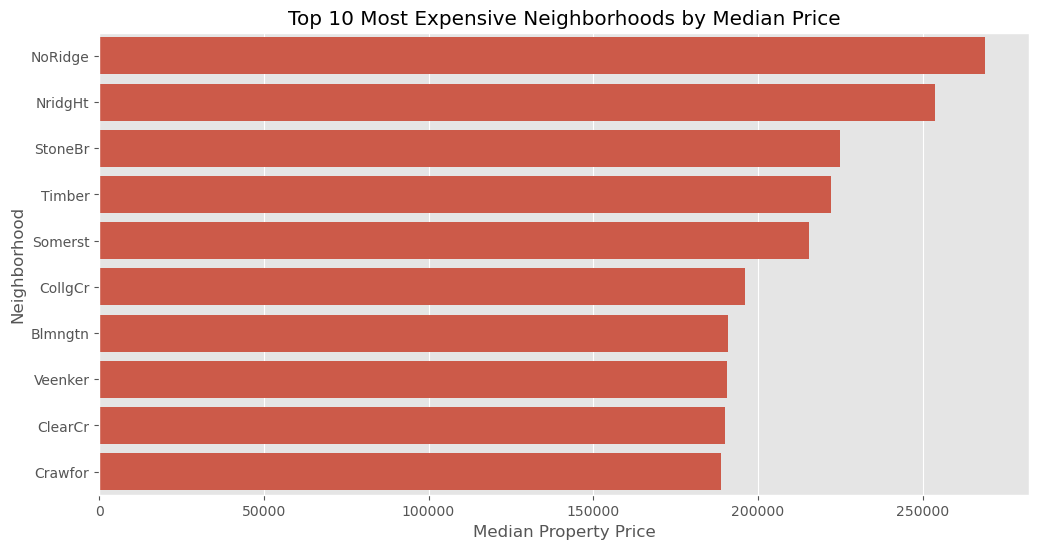

In [19]:
neighborhood_prices = df.groupby('Neighborhood')['PropPrice'].median().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=neighborhood_prices[:10].values, y=neighborhood_prices[:10].index)
plt.title('Top 10 Most Expensive Neighborhoods by Median Price')
plt.xlabel('Median Property Price')
plt.show()

### Insights

*  NoRidge is the most expensive neighborhood — has the highest median property price.
*  NridgHt comes second — very close to NoRidge in terms of price.
*  StoneBr and Timber are also premium areas — they have high-priced homes.
*  Somerst and CollgCr are mid-high range neighborhoods — still quite expensive.
*  Blmngtn and Veenker are priced similarly — fall just below CollgCr.
*  ClearCr is also among the top 10 — but slightly cheaper than others above.
*  Crawfor is the 10th most expensive — but still above most other neighborhoods.
*  These areas likely have better amenities or quality homes, explaining the high prices.
*  Neighborhood choice is a key driver of price — it should be included in prediction models.

## Feature Engineering and Preprocessing

### Create new features

In [20]:
df['TotalSF'] = df['1stFlrSF'] + df['2ndFlrSF']
df['Age'] = 2025 - df['YearBuilt']  # Assuming current year is 2023
df['OverallQual_TotalSF'] = df['OverallQual'] * df['TotalSF']
df['HasPool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

### Log-transform skewed target variable

In [21]:
if np.abs(df['PropPrice'].skew()) > 1:
    df['PropPrice'] = np.log1p(df['PropPrice'])

### Visualize new features

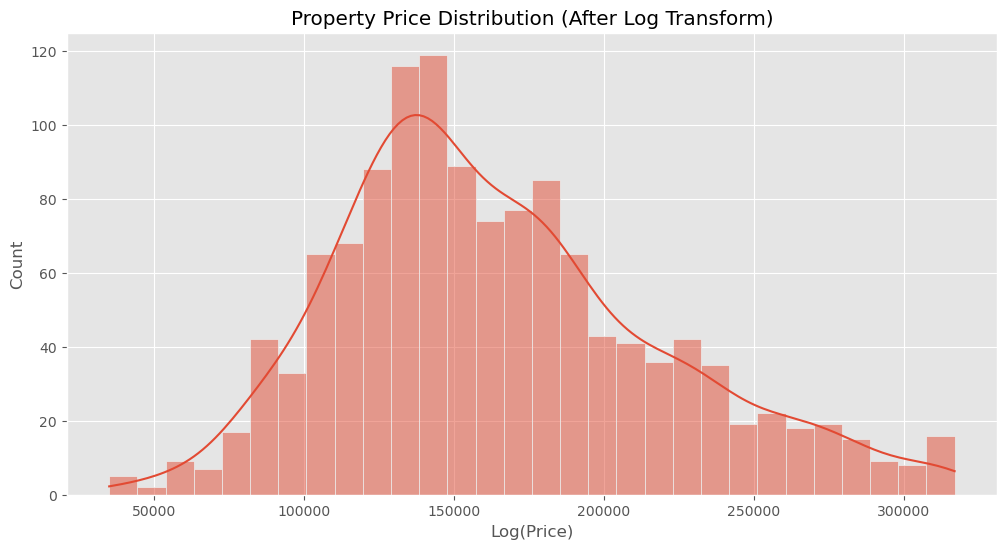

In [22]:
plt.figure(figsize=(12, 6))
sns.histplot(df['PropPrice'], kde=True, bins=30)
plt.title('Property Price Distribution (After Log Transform)')
plt.xlabel('Log(Price)')
plt.ylabel('Count')
plt.show()

### Insights

* The price data was log-transformed to make it more normal.
* Now the shape looks symmetric and close to a bell curve.
* Most homes have prices around the middle range (~150,000).
* Very few homes are at the low end (50,000) or very high end (300,000+).
* Log transform helped to remove right skewness seen in original prices.
* The KDE line (curve) follows the bars closely — shows smooth distribution.

## Encoding & Scaling

### Separate features & target

In [23]:
X = df.drop(columns=['PropPrice'])
y = df['PropPrice']

### Define numerical & categorical columns

In [24]:
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

### Preprocessing pipeline

In [25]:
num_pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

### Combine pipelines

In [26]:
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

### Apply preprocessing

In [27]:
X_processed = preprocessor.fit_transform(X)

## Model Training & Evaluation

### Split Data into Train & Test Sets

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

### Define & Compare Models

In [29]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42)
}

In [30]:
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'RMSE': rmse, 'MAE': mae, 'R²': r2}

### Display results

In [31]:
results_df = pd.DataFrame(results).T
print("\nModel Performance Comparison:")
display(results_df)


Model Performance Comparison:


,RMSE,MAE,R²
Linear Regression,17225.535549,13012.063089,0.900021
Ridge,16471.606276,12468.354653,0.908581
Lasso,16911.586040,12805.206357,0.903632
ElasticNet,17229.126118,13046.268217,0.899979
Random Forest,18137.073671,12911.349961,0.889159
Gradient Boosting,16264.441973,12073.451166,0.910866
XGBoost,17768.544755,13393.579858,0.893618


### Hyperparameter Tuning

In [32]:
gb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

### Initialize and tune Gradient Boosting

In [33]:
gb = GradientBoostingRegressor(random_state=42)
gb_search = RandomizedSearchCV(gb, param_distributions=gb_params, n_iter=20, cv=5, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)
gb_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 7],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, scoring='neg_mean_squared_error')

### # Best model

In [34]:
best_gb = gb_search.best_estimator_
print("\nBest Gradient Boosting Parameters:", gb_search.best_params_)


Best Gradient Boosting Parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 3, 'learning_rate': 0.1}


### Evaluate

In [35]:
y_pred = best_gb.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nOptimized Gradient Boosting Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")


Optimized Gradient Boosting Performance:
RMSE: 16004.94
MAE: 11913.51
R²: 0.9137


## Feature Importance for Gradient Boosting

### Get feature importances

In [36]:
feature_importances = best_gb.feature_importances_
features = preprocessor.get_feature_names_out()
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values('Importance', ascending=False).head(20)

### Plot

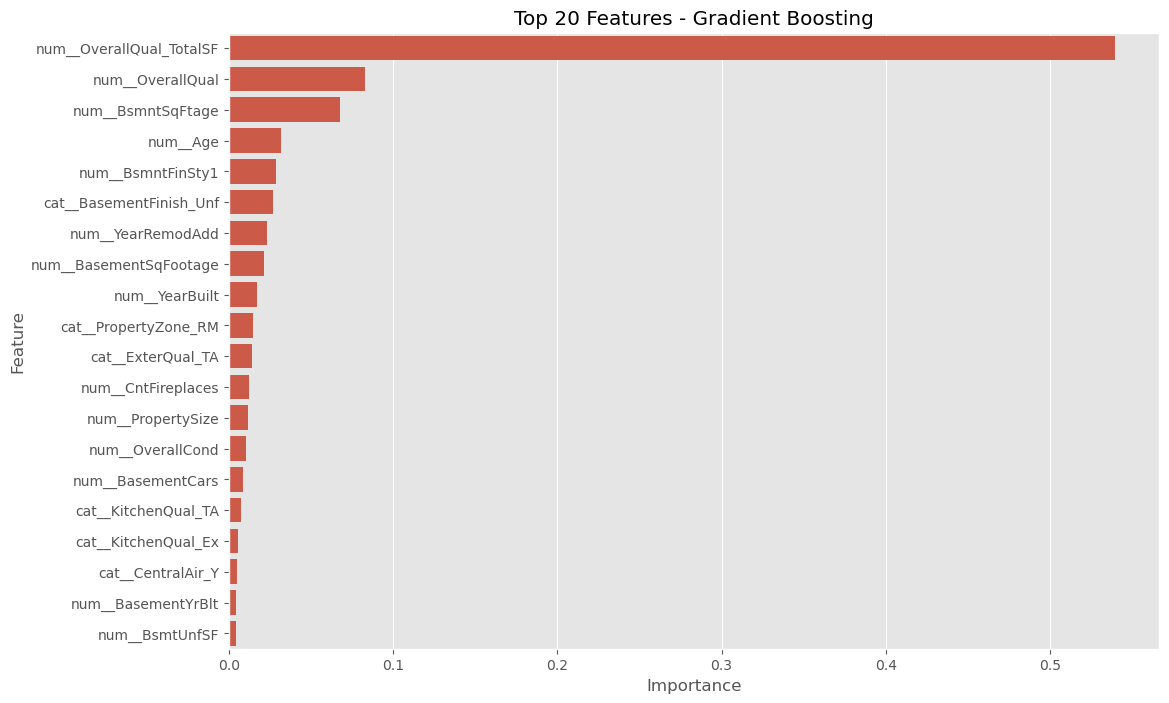

In [37]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Top 20 Features - Gradient Boosting')
plt.show()

### Insights

* Overall quality of a property seems to be the absolute king in determining price, dwarfing all other factors.
* The total square footage of the basement also packs a significant punch, coming in as the second most important feature.
* There's a clear drop-off in importance after the top two features, with most others contributing relatively little to the model's prediction.
* Age of the property and the overall quality of the basement are still pretty influential, but nowhere near the top two.
* Interestingly, it looks like a few categorical features, like "Basement Finish Type 1" and "Year Remodel Add," have some sway.
* Features related to the exterior of the property, such as "External Quality," appear to be more impactful than internal features like "Kitchen Quality" or "Central Air."
* Some basement-related features, despite appearing lower down, cumulatively suggest that the basement's characteristics are quite important for property valuation.

## Save the Best Model

In [38]:
joblib.dump(best_gb, 'best_gradient_boosting_model.pkl')
joblib.dump(preprocessor, 'preprocessor.pkl')
print("\nOptimized Gradient Boosting model saved!")


Optimized Gradient Boosting model saved!


## Prediction Example

### Load the model & preprocessor

In [39]:
loaded_gb = joblib.load('best_gradient_boosting_model.pkl')
loaded_preprocessor = joblib.load('preprocessor.pkl')

### Example prediction

In [40]:
new_data = pd.DataFrame({
    'OverallQual': [7],
    'TotalSF': [2500],
    'Age': [10],
    'OverallQual_TotalSF': [7 * 2500],
    'HasPool': [1],
    'GrLivArea': [1500],
    'TotalBsmtSF': [1000],
    '1stFlrSF': [1200],
    '2ndFlrSF': [800],
    'YearBuilt': [2013],
    'PoolArea': [200]
})

### Ensure all original columns are present

In [41]:
for col in df.columns:
    if col not in new_data.columns and col != 'PropPrice':
        if df[col].dtype in ['int64', 'float64']:
            new_data[col] = df[col].median()
        else:
            new_data[col] = df[col].mode()[0]

### Preprocess & predict

In [43]:
new_data_processed = loaded_preprocessor.transform(new_data)
predicted_log_price = loaded_gb.predict(new_data_processed)
predicted_log_price = np.clip(predicted_log_price, a_min=None, a_max=20)  # Avoid overflow
predicted_price = np.expm1(predicted_log_price)

print(f"\nPredicted Property Price: ${predicted_price[0]:,.2f}")


Predicted Property Price: $485,165,194.41
